# Sandwich shop
We want to investigate if adding an extra crew member during rush hour is worth our trouble.

#### Some relevant information:
* The arrival time between clients $\left(T\right)$ is a stochastic variable following an exponential distribution with parameter $\lambda(t)$, where $\lambda$ also depends on the time of day. From historical data we know the following about the mean time between client arrivals:
    * from 00:00 until 08:00: shop is closed
    * from 08:00 until 11:00: 25 minutes
    * from 11:00 until 14:00: 1 minutes
    * from 14:00 until 17:00: 10 minutes
    * from 17:00 until 19:00: 2 minutes
    * from 19:00 until 20:00: 5 minutes
    * from 20:00 until 24:00: shop is closed
    
    **Remark: in reality you would execute a measurements campaign and verify if the experimental distribution actually follows an exponential distribution (by means of a Kolmogorov–Smirnov test**
        
* If an employee is available the client places an order (we could also incorporate a decision time). This implies that we need the shop to have a limited `::Resource` i.e. the employees. 

    If no one is available, the client waits for his turn, but has a limited amount of patience. When this runs out, the clients leaves the shop (and should cancel his request for the employee `Resource`). Patience for the different clients is defined as a random variable $\sim\mathcal{U}(5,10)$. 
    * `Resource.level` is the current amount of resources in use
    * `Resource.capacity` is the total amount of resources
    * `Resource.put_queue` are the scheduled processes for the resource and can be used for queue length
* Once the order is placed, the preperation time is also a random variable.

#### Topics:

1. We need to log the activities in our shop:
    1. Queue build-up $\rightarrow$ logging of queue required
    2. Waiting times $\rightarrow$ logging of waiting times required

#### Some food for thought:
* What if we considered clients with a memory? I.e. if they do not get served within their patience range, they go away and spread they word (which in its turn influences future arrival rates).
* Is the extra person worth it from an economic point of view?
* Could you also include orders that are place by phone before a specific time (also requiring the staff's attention)?
*Tto get the authentic shop feeling, we could use the `Dates` package and use actual date and hour for the plots

### Dependencies, Logging setup and supporting functions:
* Plots will be made using the [Plots](http://docs.juliaplots.org/latest/) package. 
* The [Distributions](https://juliastats.github.io/Distributions.jl/stable/) package will be used for distributions and randomness. 
* The [Logging](https://docs.julialang.org/en/v1/stdlib/Logging/index.html) module will be used for efficient debugging and testing during development.
* The [StatsBase](http://juliastats.github.io/StatsBase.jl/latest/index.html) package provides basic support for statistics. We will use it for experimental PDF and CDF in particular.
* The [HypothesisTests]() package contains hypothesis tests that can use to test if our data follows a specific distribution (e.g. normality with a KS-test) or to determine confidence intervals on data (e.g. 95% CI for mean waiting time).



In [1]:
# Dependencies
using Dates              # for actual time & date
using Distributions      # for distributions and random behaviour
using HypothesisTests    # for more statistical analysis
using Logging            # for debugging
using Plots              # for figures
using StatsPlots         # for nicer histograms (cf. solution)
using SimJulia           # for DES
using Statistics         # for statistics

# Available items in the shop
const menulist = ["sandwich, cold","sandwich, hot","pasta","soup"]  # names
const menuprob = Distributions.Categorical([0.6,0.2,0.1,0.1])       # probabilities
const preptimes = Dict( menulist[1]=>Distributions.Uniform(60,90),  # prepatation times
                        menulist[2]=>Distributions.Uniform(60,120), 
                        menulist[3]=>Distributions.Uniform(60,90),
                        menulist[4]=>Distributions.Uniform(30,45))

# Configuring the logger (general)
mylogger = Logging.SimpleLogger(stdout,LogLevel(-10000))
Logging.global_logger(mylogger)
Logging.disable_logging(LogLevel(-4500));

# Explicitly import Base.show in order to use it for our own types
import Base.show

"""
nextarrival(t::DateTime)

Return time between client arrival in milliseconds. 
This implies that milliseconds are the smallest time resolution in our simulation."""
function nextarrival(t::DateTime)
    if (hour(t) >= 8) & (hour(t) < 11)
        d = Distributions.Exponential(25*60000)
    elseif (hour(t) >= 11) & (hour(t) < 14)
        d = Distributions.Exponential(1*60000)
    elseif (hour(t) >= 14) & (hour(t) < 17)
        d = Distributions.Exponential(10*60000)
    elseif (hour(t) >= 17) & (hour(t) < 19)
        d = Distributions.Exponential(2*60000)
    elseif (hour(t) >= 19) & (hour(t) < 20)
        d = Distributions.Exponential(5*60000)
    else
        return nothing
    end
    
    return Millisecond(round(rand(d)))
end;

Some tips:
* You can round a `DateTime` e.g.
```Julia
    round(Dates.now(),Minute)
```
* You can use a `DateTime` within a simulation e.g.
```Julia
    tstart = floor(now(),Day) # start on current day, rounded downwards (why?)
    sim = Simulation(tstart)  # setup simulation starting on tstart
    run(sim, tstart + Day(3)) # run the simulation for three days
```
* The current time of the simulation (as a DateTime) can be obtained with `nowDatetime(sim)`.
* Make a schematical represenation of what is going on and who needs to "communicate" with whom.
* Think about how you will implement all of this (types, field, storage of useful information, opening times etc.)
* You can use a specific logger for a function in order to seperate different information streams e.g.
```Julia
    const globlogger = Logging.SimpleLogger(stdout,LogLevel(-10000)) 
    Logging.global_logger(mylogger)     # set global logger
    io = open("log.txt", "w+")          # select file
    myspecificlogger = SimpleLogger(io) # pair logger with IOStream
    function foo(x...; logger=globlogger)
        with_logger(logger) do
            @info "Total of $(length(x)) arguments:"
            for i in x
                @info("Value of argument: $(i)")
            end
       end 
    end

    foo([1;2;3],"another input","and another",5)
    foo([1;2;3],"another input","and another",5,logger=myspecificlogger)
    close(io)
```


### Arrival process and initial verifications:

In [93]:
@resumable function arrivals(sim::Simulation, shop::Shop, topen=8,tclose=20)
    while true
        # te vroeg
        if hour(nowDatetime(sim)) < topen
            twait = floor(nowDatetime(sim),Day) + Hour(topen) - nowDatetime(sim)
            @info "te vroeg, ik wacht $(twait)"
            @yield timeout(sim,twait)
        end
        # te laat
        if hour(nowDatetime(sim)) >= tclose
            twait = floor(nowDatetime(sim),Day) + Hour(topen) + Day(1) - nowDatetime(sim)
            @info "te laat, ik wacht $(twait)"
            @yield timeout(sim,twait)
        end
        # open
        #@info "$(nowDatetime(sim)): nieuwe klant"
        @yield timeout(sim,nextarrival(nowDatetime(sim)))
        Client(sim, shop)
    end
end

arrivals (generic function with 6 methods)

In [12]:
tstart = floor(now(),Day) # start on current day, rounded downwards (why?)
sim = Simulation(tstart)  # setup simulation starting on tstart
@process arrivals(sim)
run(sim, tstart + Day(1)) # run the simulation for three days

┌ Info: te vroeg, ik wacht 28800000 milliseconds
└ @ Main In[11]:6
┌ Info: 2019-11-05T08:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T09:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T10:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T11:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T12:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T13:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T14:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T15:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T16:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T17:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T18:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-05T19:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: te laat, ik wacht 43200000 milliseconds
└ @ Main In[11]:12
┌ Info: 2019-11-06T08:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019-11-06T09:00:00: nieuwe klant
└ @ Main In[11]:16
┌ Info: 2019

### Include store and client behavior & run a single simulation

In [67]:
mutable struct Shop
    staff::Resource
    queuelength::Array
    clients::Dict
    waitingtimes::Array
    renegtimes::Array
    function Shop(sim::Simulation, nstaff::Int=1)
        s = new()
        s.staff = Resource(sim, nstaff)
        s.queuelength = [(nowDatetime(sim),0)]
        s.clients = Dict()
        s.waitingtimes = []
        s.renegtimes = []
        return s
    end
end

function show(io::IO, s::Shop)
    print(io,"Shop with:
        - $(s.staff.capacity) employees, $(s.staff.capacity - s.staff.level) available; 
        - $(length(s.clients)) clients")
end

mutable struct Client
    id::Int
    patience::Int # in seconden
    proc::Process
    function Client(sim::Simulation,shop::Shop)
        c = new()
        c.id = length(shop.clients) + 1
        c.patience = round(rand(Uniform(5*60, 10*60))) # in seconden
        c.proc = @process client_behavior(sim, c, shop)
        # steek klant in klantenbestand
        shop.clients[c.id] = c
        return c
    end
end

function show(io::IO, c::Client)
    print(io,"Client N°$(c.id) with $(c.patience) patience")
end

show (generic function with 436 methods)

In [102]:
@resumable function client_behavior(sim::Simulation, c::Client, s::Shop)
    # kiezen tussen 0-60 seconden
    @yield timeout(sim, Second(round(rand(Uniform(0,60)))))
    choice = menulist[rand(menuprob)]
    @info "$(nowDatetime(sim)) $c.id - ik kies voor $(choice)"
    # bediend worden`
    # lengte wachtrij?
    push!(s.queuelength, (nowDatetime(sim), length(s.staff.put_queue)))
    tsin = nowDatetime(sim) #tijdstip begin wachten
    req = request(shop.staff)
    res = @yield req | timeout(sim, Second(c.patience)) # ofwel één ofwel ander
    if res[req].state == SimJulia.processed  # geval ik word bediend
        # maak een broodje
        @yield timeout(sim, Second(round(rand(preptimes[choice]))))
        tsout = nowDatetime(sim) #tijdstip eind wachten
        deltat = tsout - tsin 
        push!(s.waitingtimes, deltat)
        release(shop.staff)
        @info "$(nowDatetime(sim)) - Ik ben bediend"
    else
        # ga weg
        cancel(shop.staff, req)
        push!(s.renegtimes, nowDatetime(sim))
        @info "$(nowDatetime(sim)) - IK GA WEG EN BEN BOOS"
    end
    
end


client_behavior (generic function with 1 method)

In [103]:
tstart = floor(now(),Day) # start on current day, rounded downwards (why?)
sim = Simulation(tstart)  # setup simulation starting on tstart
shop = Shop(sim, 1)
@process arrivals(sim, shop)
run(sim, tstart + Day(1)) # run the simulation for three days

┌ Info: te vroeg, ik wacht 28800000 milliseconds
└ @ Main In[93]:6
┌ Info: 2019-11-05T08:41:23.799 Client N°1 with 420 patience.id - ik kies voor sandwich, cold
└ @ Main In[102]:5
┌ Info: 2019-11-05T08:42:52.799 - Ik ben bediend
└ @ Main In[102]:19
┌ Info: 2019-11-05T09:07:01.345 Client N°2 with 473 patience.id - ik kies voor sandwich, cold
└ @ Main In[102]:5
┌ Info: 2019-11-05T09:08:02.345 - Ik ben bediend
└ @ Main In[102]:19
┌ Info: 2019-11-05T09:55:28.9 Client N°3 with 355 patience.id - ik kies voor soup
└ @ Main In[102]:5
┌ Info: 2019-11-05T09:56:12.9 - Ik ben bediend
└ @ Main In[102]:19
┌ Info: 2019-11-05T10:03:42.091 Client N°4 with 445 patience.id - ik kies voor sandwich, cold
└ @ Main In[102]:5
┌ Info: 2019-11-05T10:05:05.091 - Ik ben bediend
└ @ Main In[102]:19
┌ Info: 2019-11-05T10:14:24.865 Client N°5 with 525 patience.id - ik kies voor sandwich, cold
└ @ Main In[102]:5
┌ Info: 2019-11-05T10:15:29.865 - Ik ben bediend
└ @ Main In[102]:19
┌ Info: 2019-11-05T10:33:53.25 Client

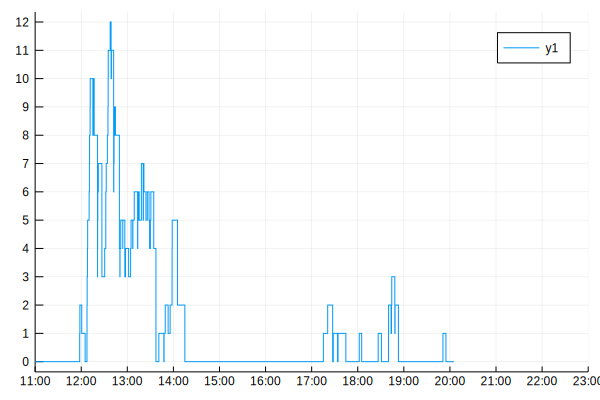

In [125]:
# prentje wachtrij
x = [t[1] for t in shop.queuelength]
y = [t[2] for t in shop.queuelength]

plot(x,y,line=:steppost)
# some makeup
tstart = floor(Dates.now(),Day)+Hour(11)
tstop = floor(Dates.now(),Day)+Hour(23)
daterange =  tstart : Minute(60) : tstop
datexticks = [Dates.value(mom) for mom in daterange]
datexticklabels = Dates.format.(daterange,"HH:MM")#Dates.format.(daterange, "HH:MM")

xticks!(datexticks, datexticklabels,rotation=0)
xlims!(Dates.value(tstart),Dates.value(tstop))
yticks!(0:1:12)

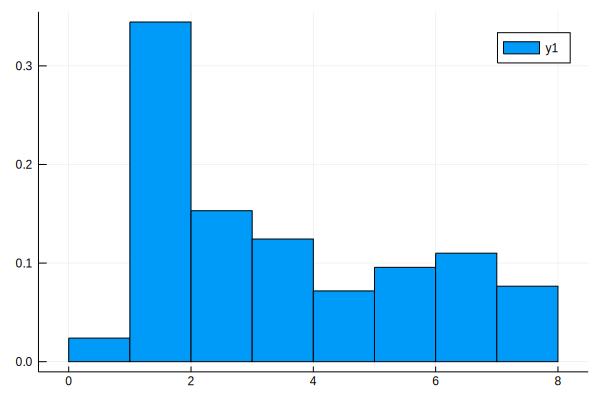

In [135]:
twait = Dates.value.(shop.waitingtimes) ./ 1000 / 60 # wachttijden in minuten
StatsPlots.histogram(twait,bins=[0; 1; 2; 3; 4; 5; 6; 7; 8],normalize=:probability)

## Analyze trends with several simulations

## Parameter study
Add the variable staffing aspect an look at its impact on the waiting times, renegs etc.